In [19]:
import pandas as pd
import numpy as np

https://pmc.ncbi.nlm.nih.gov/articles/PMC4120446/

https://github.com/Meriadoc-gitgit/pen-based-recognition-of-handwritten-digits

https://github.com/Meriadoc-gitgit/inferential-statistics

In [25]:
initial_threshold_pace = "2:15"  # Example threshold
initial_threshold_spm = 35  # Example threshold for SPM

In [26]:
def is_exhausted(row, threshold_pace="2:15", threshold_spm=35):
    # Convert the pace to seconds for comparison
    pace_seconds = int(row['split_avg_pace'].split(":")[0]) * 60 + float(row['split_avg_pace'].split(":")[1])
    threshold_pace_seconds = int(threshold_pace.split(":")[0]) * 60 + float(threshold_pace.split(":")[1])
    
    return pace_seconds > threshold_pace_seconds or row['split_stroke_rate'] > threshold_spm

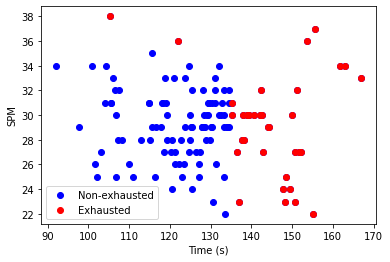

In [27]:
df['exhausted'] = df.apply(is_exhausted, axis=1)
exhausted_rows = df[df['exhausted'] == True]

# Plot the results
plt.scatter(df['split_time'], df['split_stroke_rate'], color='blue', label='Non-exhausted')
plt.scatter(exhausted_rows['split_time'], exhausted_rows['split_stroke_rate'], color='red', label='Exhausted')
plt.xlabel('Time (s)')
plt.ylabel('SPM')
plt.legend()
plt.show()

In [28]:
# Example of creating a true exhaustion label based on certain criteria
df['true_exhaustion'] = df['split_avg_pace'].apply(lambda x: 1 if x > "2:15" else 0)  # 1 indicates exhausted, 0 indicates not exhausted
true_exhaustion_labels = df['exhausted']

In [29]:
from sklearn.metrics import accuracy_score

# Try different thresholds and compare accuracy
thresholds_pace = ["2:10", "2:15", "2:20"]
thresholds_spm = [30, 35, 40]

for pace in thresholds_pace:
    for spm in thresholds_spm:
        df['exhausted'] = df.apply(is_exhausted, threshold_pace=pace, threshold_spm=spm, axis=1)
        accuracy = accuracy_score(true_exhaustion_labels, df['exhausted'])
        print(f'Pace Threshold: {pace}, SPM Threshold: {spm} -> Accuracy: {accuracy}')

Pace Threshold: 2:10, SPM Threshold: 30 -> Accuracy: 0.640625
Pace Threshold: 2:10, SPM Threshold: 35 -> Accuracy: 0.828125
Pace Threshold: 2:10, SPM Threshold: 40 -> Accuracy: 0.8125
Pace Threshold: 2:15, SPM Threshold: 30 -> Accuracy: 0.7421875
Pace Threshold: 2:15, SPM Threshold: 35 -> Accuracy: 1.0
Pace Threshold: 2:15, SPM Threshold: 40 -> Accuracy: 0.984375
Pace Threshold: 2:20, SPM Threshold: 30 -> Accuracy: 0.6796875
Pace Threshold: 2:20, SPM Threshold: 35 -> Accuracy: 0.9296875
Pace Threshold: 2:20, SPM Threshold: 40 -> Accuracy: 0.9140625


    participant  cluster  place  speed_kmh  split_stroke_rate
0          Eric        2   16.5  15.075377                 28
1          Eric        2   22.5  14.851485                 26
2          Eric        2   22.5  14.851485                 27
3          Eric        2    7.0  15.584416                 29
4       Edouard        2    4.5  15.679443                 31
..          ...      ...    ...        ...                ...
123       Julie        2   59.5  13.740458                 33
124       Hervé        2   39.5  14.150943                 26
125       Hervé        2   69.5  13.493253                 25
126       Hervé        2   78.0  13.186813                 27
127       Hervé        2   66.0  13.554217                 31

[128 rows x 5 columns]


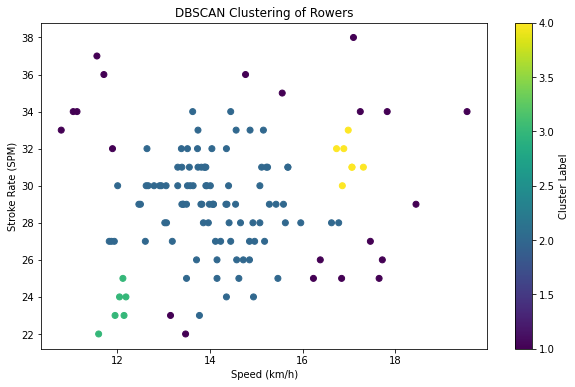

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Assuming these columns are relevant for clustering
features = df[['speed_kmh', 'split_stroke_rate']]  # Choose appropriate features

# Normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Fit DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
df['cluster'] = dbscan.fit_predict(scaled_features)
df['cluster'] = [df['cluster'][i]+2 for i in range(len(df))]

# Calculate the average speed and stroke rate per cluster
cluster_means = df.groupby('cluster')[['speed_kmh', 'split_stroke_rate']].mean().reset_index()

# Assign rankings within each cluster
df['place'] = df.groupby('cluster')['speed_kmh'].rank(ascending=False)

# Display the final DataFrame with clusters and places
print(df[['participant', 'cluster', 'place', 'speed_kmh', 'split_stroke_rate']])

# Optional: Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(df['speed_kmh'], df['split_stroke_rate'], c=df['cluster'], cmap='viridis', label='Clusters')
plt.title('DBSCAN Clustering of Rowers')
plt.xlabel('Speed (km/h)')
plt.ylabel('Stroke Rate (SPM)')
plt.colorbar(label='Cluster Label')
plt.show()

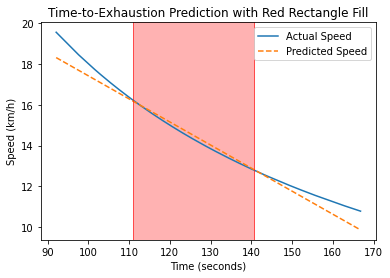

In [61]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load the data
df = pd.read_json("Test/ergometer_500m.json")

# Define target variable (e.g., speed) and features (time)
X = df['split_time'].values.reshape(-1, 1)  # Time as the independent variable
# Calculate speed in km/h (distance in km / time in hours)
df['split_time_hours'] = df['split_time'] / 3600  # Convert time to hours
df['speed_kmh'] = (0.5 / df['split_time_hours'])  # Distance is 0.5 km (500m)
y = df['speed_kmh'].values  # Speed as the dependent variable

# Linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict speed over time
predicted_speed = model.predict(X)

# Convert X to a 1D array for proper handling
Xp = X.flatten()  # Flatten the 2D array into 1D
arg = np.argsort(Xp)  # Sort X values for proper plotting
Xp_sorted = Xp[arg]
y_sorted = y[arg]
predicted_speed_sorted = predicted_speed[arg]

# Plot the actual vs predicted speed over time
plt.plot(Xp_sorted, y_sorted, label='Actual Speed')
plt.plot(Xp_sorted, predicted_speed_sorted, label='Predicted Speed', linestyle='--')

# Find intersections where actual and predicted speeds cross
intersections = np.where(np.diff(np.sign(y_sorted - predicted_speed_sorted)))[0]

# If there are intersections, color the area between the two lines
if len(intersections) > 1:
    # Get intersection points
    x_fill_start = Xp_sorted[intersections[0]]
    x_fill_end = Xp_sorted[intersections[1]]
    
    # Draw vertical lines at the intersection points
    plt.axvline(x_fill_start, color='red', linestyle='-', linewidth=0.5)
    plt.axvline(x_fill_end, color='red', linestyle='-', linewidth=0.5)

    # Fill the entire rectangle area between the two vertical lines
    plt.axvspan(x_fill_start, x_fill_end, color='red', alpha=0.3)

# Add title, labels, and legend
plt.title('Time-to-Exhaustion Prediction with Red Rectangle Fill')
plt.xlabel('Time (seconds)')
plt.ylabel('Speed (km/h)')
plt.legend()
plt.show()